# 1. Importing Libraries

In [6]:
import numpy as np 
import pandas as pd 
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

# 2. Data Preparation

In [7]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)   

,dirname,filename
89,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
81,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
142,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
31,../input/liver-tumor-segmentation/segmentations,segmentation-100.nii
45,../input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...
166,../input/liver-tumor-segmentation/volume_pt5,volume-50.nii
27,../input/liver-tumor-segmentation/volume_pt1,volume-6.nii
30,../input/liver-tumor-segmentation/volume_pt1,volume-7.nii
21,../input/liver-tumor-segmentation/volume_pt1,volume-8.nii


In [8]:
# Map CT scan and label 


df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "../input/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files

,dirname,filename,mask_dirname,mask_filename
0,../input/liver-tumor-segmentation/volume_pt1,volume-0.nii,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,../input/liver-tumor-segmentation/volume_pt1,volume-1.nii,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,../input/liver-tumor-segmentation/volume_pt1,volume-10.nii,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,../input/liver-tumor-segmentation/volume_pt2,volume-11.nii,../input/liver-tumor-segmentation/segmentations,segmentation-11.nii
4,../input/liver-tumor-segmentation/volume_pt2,volume-12.nii,../input/liver-tumor-segmentation/segmentations,segmentation-12.nii
5,../input/liver-tumor-segmentation/volume_pt2,volume-13.nii,../input/liver-tumor-segmentation/segmentations,segmentation-13.nii
6,../input/liver-tumor-segmentation/volume_pt2,volume-14.nii,../input/liver-tumor-segmentation/segmentations,segmentation-14.nii
7,../input/liver-tumor-segmentation/volume_pt2,volume-15.nii,../input/liver-tumor-segmentation/segmentations,segmentation-15.nii
8,../input/liver-tumor-segmentation/volume_pt2,volume-16.nii,../input/liver-tumor-segmentation/segmentations,segmentation-16.nii
9,../input/liver-tumor-segmentation/volume_pt2,volume-17.nii,../input/liver-tumor-segmentation/segmentations,segmentation-17.nii


# 3. Data Preprocessing

In [9]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [10]:
# Read sample

sample = 40
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 74)
Mask Shape: (512, 512, 74)


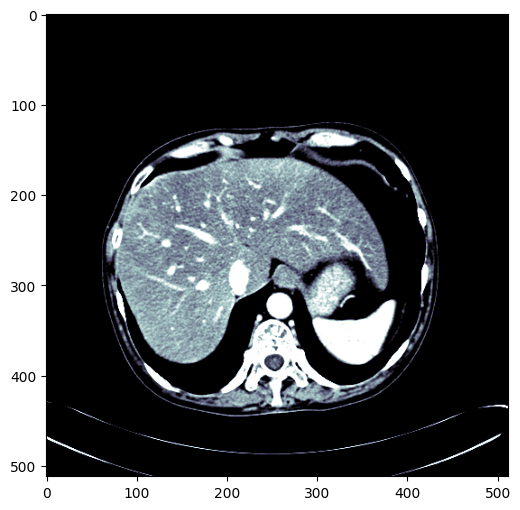

In [11]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)

plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

# Data Visualization
## Display Sample Images

In [12]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('off')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')
    
    plt.show()

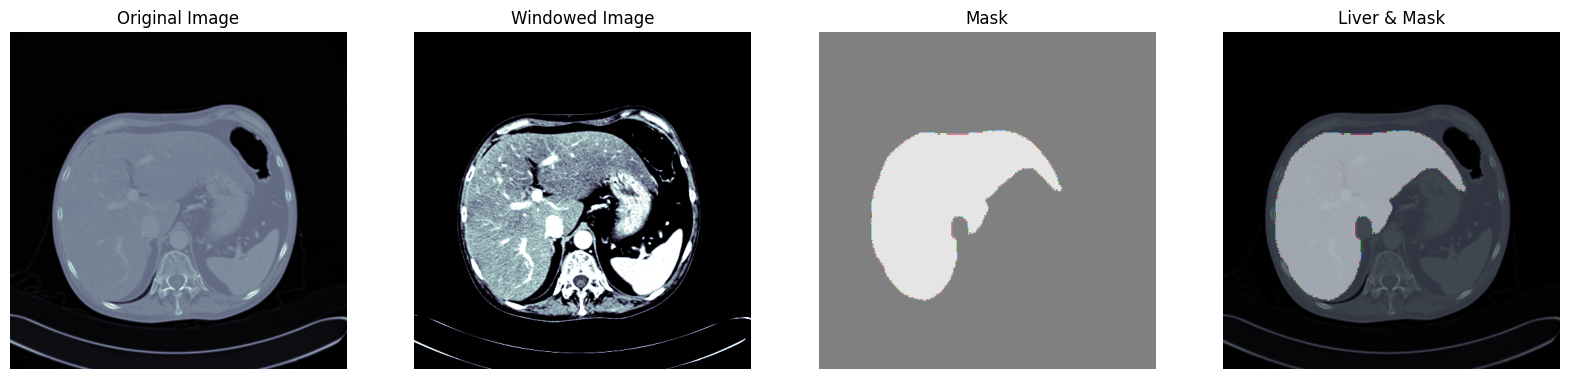

In [13]:
sample = 45

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

<Axes: >

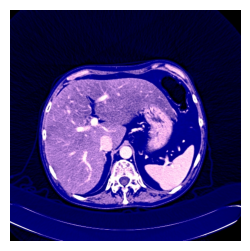

In [14]:
# Preprocessing functions
class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'} #a subclass of a PyTorch Tensor designed to handle black-and-white images.

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)


@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=120): #unction to convert the tensor to a multi-channel image suitable for saving as a JPG.The image is saved with the specified quality.
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs = subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))

# 4. Generate Training Image From 'nii' File

In [15]:
from sklearn.model_selection import train_test_split

GENERATE_JPG_FILES = True

if GENERATE_JPG_FILES:

    path = Path(".")

    os.makedirs('train_images', exist_ok=True)
    os.makedirs('train_masks', exist_ok=True)

    ## test folder
    os.makedirs('test_images', exist_ok=True)
    os.makedirs('test_masks', exist_ok=True)

    # Split the data into train and test sets
    train_df, test_df = train_test_split(df_files, test_size=0.1, random_state=42)

    # Check if train_df is empty
    print("Length of train_df:", len(train_df))

    # Reset index for contiguous indices
    train_df = train_df.reset_index(drop=True)
    # Check if test_df is empty
    print("Length of test_df:", len(test_df))
    test_df = test_df.reset_index(drop=True)

    # Loop for training set
    for ii in tqdm(range(len(train_df))):
        curr_ct = read_nii(train_df.loc[ii, 'dirname'] + "/" + train_df.loc[ii, 'filename'])
        curr_mask = read_nii(train_df.loc[ii, 'mask_dirname'] + "/" + train_df.loc[ii, 'mask_filename'])
        curr_file_name = str(train_df.loc[ii, 'filename']).split('.')[0]
        curr_dim = curr_ct.shape[2]

        for curr_slice in range(0, curr_dim, 2):
            data = tensor(curr_ct[..., curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver, dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")

    ### test image save
    for ii in tqdm(range(len(test_df))):
        curr_ct = read_nii(test_df.loc[ii, 'dirname'] + "/" + test_df.loc[ii, 'filename'])
        curr_mask = read_nii(test_df.loc[ii, 'mask_dirname'] + "/" + test_df.loc[ii, 'mask_filename'])
        curr_file_name = str(test_df.loc[ii, 'filename']).split('.')[0]
        curr_dim = curr_ct.shape[2]

        for curr_slice in range(0, curr_dim, 2):
            data = tensor(curr_ct[..., curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"test_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver, dicom_windows.custom])
            mask.save(f"test_masks/{curr_file_name}_slice_{curr_slice}_mask.png")

else:
    path = Path("../input/liver-segmentation-with-fastai-v2")  # read jpg from saved kernel output

Length of train_df: 45
Length of test_df: 6


  0%|          | 0/45 [00:00<?, ?it/s]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


  0%|          | 0/6 [00:00<?, ?it/s]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


## 4.1 - Check Data

In [16]:
print("\nFirst few rows of Training Set:")
print(train_df.head())

print("\nFirst few rows of Testing Set:")
print(test_df.head())


First few rows of Training Set:
                                        dirname       filename  \
0  ../input/liver-tumor-segmentation/volume_pt3  volume-24.nii   
1  ../input/liver-tumor-segmentation/volume_pt4  volume-38.nii   
2  ../input/liver-tumor-segmentation/volume_pt2  volume-11.nii   
3  ../input/liver-tumor-segmentation/volume_pt4  volume-36.nii   
4  ../input/liver-tumor-segmentation/volume_pt2  volume-20.nii   

                                      mask_dirname        mask_filename  
0  ../input/liver-tumor-segmentation/segmentations  segmentation-24.nii  
1  ../input/liver-tumor-segmentation/segmentations  segmentation-38.nii  
2  ../input/liver-tumor-segmentation/segmentations  segmentation-11.nii  
3  ../input/liver-tumor-segmentation/segmentations  segmentation-36.nii  
4  ../input/liver-tumor-segmentation/segmentations  segmentation-20.nii  

First few rows of Testing Set:
                                        dirname       filename  \
0  ../input/liver-tumor-segm

In [17]:
print("\ntrain df data shape:")
print(train_df.shape)


train df data shape:
(45, 4)


In [18]:
print("\ntest df data shape:")
print(test_df.shape)


test df data shape:
(6, 4)


# 5. Resizing Images

In [19]:
# Set the directories
train_images_dir = '/kaggle/working/train_images'
train_masks_dir = '/kaggle/working/train_masks'

# Get the list of image file names
all_image_file_names = sorted(os.listdir(train_images_dir))

# Determine the sample size
sample_size = min(9000, len(all_image_file_names))

# Randomly select images
selected_image_file_names = random.sample(all_image_file_names, sample_size)

# Load selected images and masks with resizing nd converted to numpy arrays
target_size = (128, 128)
train_images = [np.array(Image.open(os.path.join(train_images_dir, fname)).resize(target_size)) for fname in selected_image_file_names]

# Adjust file extension for masks 
mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]
train_masks = [np.array(Image.open(os.path.join(train_masks_dir, fname)).resize(target_size)) for fname in mask_file_names]

# Convert the lists to numpy arrays  for further processing
train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Normalize images to [0, 1]
train_images =train_images / 255.0

# Reshape masks to include a channel dimension
train_masks =train_masks.reshape((train_masks.shape[0], train_masks.shape[1], train_masks.shape[2], 1))

In [20]:
# Set the directories
test_images_dir = '/kaggle/working/test_images'
test_masks_dir = '/kaggle/working/test_masks'

# Get the list of image file names
all_image_file_names = sorted(os.listdir(test_images_dir))

# Determine the sample size
sample_size = min(9000, len(all_image_file_names))

# Randomly select images
selected_image_file_names = random.sample(all_image_file_names, sample_size)

# Load selected images and masks with resizing
target_size = (128, 128)
test_images = [np.array(Image.open(os.path.join(test_images_dir, fname)).resize
                        (target_size)) for fname in selected_image_file_names]

# Adjust file extension for masks
mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]
test_masks = [np.array(Image.open(os.path.join(test_masks_dir, fname)).resize
                       (target_size)) for fname in mask_file_names]

# Convert the lists to numpy arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)

# Normalize images to [0, 1]
test_images =test_images / 255.0

# Reshape masks to include a channel dimension
test_masks =test_masks.reshape((test_masks.shape[0], test_masks.shape[1], test_masks.shape[2], 1))

In [21]:
print(f"Train image ={len(train_images)} Test image={len(test_images)}")
print(f"Train mask ={len(train_masks)}  Test mask={len(test_masks)}")

Train image =8556 Test image=699
Train mask =8556  Test mask=699


# 6. Spliting Data Train Test and Validation

In [22]:
x_valid, x_test, y_valid, y_test = train_test_split(test_images, test_masks, test_size=1/3, random_state=42)

In [23]:
print(f"train image={train_images.shape} and train_masks={train_masks.shape}")
print(f"X valid shape ={x_valid.shape} x_test={x_test.shape}")
print(f"y valid shape ={y_valid.shape}  y_test={y_test.shape}")

train image=(8556, 128, 128, 3) and train_masks=(8556, 128, 128, 1)
X valid shape =(466, 128, 128, 3) x_test=(233, 128, 128, 3)
y valid shape =(466, 128, 128, 1)  y_test=(233, 128, 128, 1)


## 6.2  Display Random Images and Masks

In [24]:
def display_images_and_masks(images, masks, num_samples=2):
    # Randomly select 'num_samples' number of indices from the available images.
    sample_indices = random.sample(range(images.shape[0]), num_samples)
    
    # Loop through each sample.
    for i in range(num_samples):
        index = sample_indices[i]  # Get the index of the current sample.
        
        #  Display the image.
        plt.subplot(num_samples, 2, 2 * i + 1)  # Prepare a subplot.
        plt.imshow(images[index])  # Show the image at the selected index.
        plt.title("Image {}".format(index))  # Set the title for the image.
        plt.axis("off")  # Turn off the axis.
        
        #  Display the corresponding mask.
        plt.subplot(num_samples, 2, 2 * i + 2)  # Prepare the next subplot.
        plt.imshow(masks[index].squeeze(), cmap='gray')  # Show the mask with a grayscale colormap.
        plt.title("Mask {}".format(index))  # Set the title for the mask.
        plt.axis("off")  # Turn off the axis.
    
    # Display all the subplots.
    plt.show()

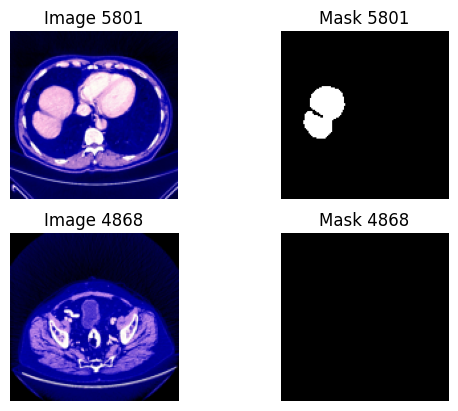

In [25]:
# Display two random images and masks
display_images_and_masks(train_images, train_masks)

# 7. Model Training

## 7.1 - Hybrid CNN SVM

In [24]:
import tensorflow as tf
import numpy as np

# Step 1: Define and compile the CNN model
input_shape = x_train.shape[1:]  # Shape of each image

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),  # Explicitly define input shape
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_valid, y_valid))

# Step 2: Initialize the model by running a dummy forward pass
# A single batch of dummy data is passed through to initialize the layers
cnn_model.predict(np.zeros((1,) + input_shape))  # Pass dummy data with correct shape to initialize the model

# Step 3: Feature extraction
# Find the last convolutional layer before flatten
conv_layer_index = -4  # Update based on your model architecture (before Flatten)

# Extract features from the last convolutional layer (before flattening)
feature_extractor = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[conv_layer_index].output)

# Step 4: Extract features from train, validation, and test sets
train_features = feature_extractor.predict(x_train)
valid_features = feature_extractor.predict(x_valid)
test_features = feature_extractor.predict(x_test)

# Check the shape of the extracted features
print("Train features shape:", train_features.shape)
print("Validation features shape:", valid_features.shape)
print("Test features shape:", test_features.shape)

# Step 5: Define SVM manually using the extracted CNN features
class LinearSVM:
    def __init__(self, C=1.0):
        self.C = C  # Regularization parameter
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        # Initialize weights and bias
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        # Gradient descent for optimization
        learning_rate = 0.001
        epochs = 1000

        # Iterate through epochs
        for _ in range(epochs):
            for i in range(num_samples):
                condition = y[i] * (np.dot(X[i], self.weights) + self.bias) >= 1
                if condition:
                    self.weights -= learning_rate * (2 * 1/self.C * self.weights)
                else:
                    self.weights -= learning_rate * (2 * 1/self.C * self.weights - np.dot(X[i], y[i]))
                    self.bias -= learning_rate * y[i]

    def predict(self, X):
        # Predict labels based on the learned weights and bias
        return np.sign(np.dot(X, self.weights) + self.bias)

# Step 6: Train the SVM model with the extracted features
svm = LinearSVM(C=1.0)
svm.fit(train_features, y_train)

# Step 7: Evaluate the performance on validation and test sets
valid_predictions = svm.predict(valid_features)
test_predictions = svm.predict(test_features)

# Classification report (manual evaluation)
from sklearn.metrics import classification_report

print("Validation classification report:")
print(classification_report(y_valid, valid_predictions))
print("Test classification report:")
print(classification_report(y_test, test_predictions))


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9829 - loss: 0.0456 - val_accuracy: 0.9970 - val_loss: 0.0096
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9982 - loss: 0.0054 - val_accuracy: 0.9970 - val_loss: 0.0109
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9987 - loss: 0.0040 - val_accuracy: 0.9992 - val_loss: 0.0044
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9990 - loss: 0.0029 - val_accuracy: 0.9989 - val_loss: 0.0039
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9993 - loss: 0.0020 - val_accuracy: 0.9985 - val_loss: 0.0083
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


ValueError: The layer sequential_19 has never been called and thus has no defined input.

In [ ]:
!pip install spektral tensorflow

In [28]:
!pip uninstall spektral


Found existing installation: spektral 1.3.1
Uninstalling spektral-1.3.1:
  Would remove:
    /opt/conda/lib/python3.10/site-packages/spektral-1.3.1.dist-info/*
    /opt/conda/lib/python3.10/site-packages/spektral/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [32]:
import spektral
print(spektral.__version__)


1.3.1


In [ ]:
pip install --upgrade spektral

In [33]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.4 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

class GNNModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.conv2 = GCNConv(64, 64)
        self.conv3 = GCNConv(64, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Example to create a graph structure from data (here, dummy data)
x = torch.rand(10, 3)  # 10 nodes with 3 features each
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)  # Edges (directed graph)

data = Data(x=x, edge_index=edge_index)

# Instantiate model and run a forward pass
model = GNNModel(in_channels=3, out_channels=2)
out = model(data.x, data.edge_index)
print(out)


tensor([[-0.6686, -0.7183],
        [-0.6585, -0.7290],
        [-0.6606, -0.7268],
        [-0.6826, -0.7038],
        [-0.7011, -0.6852],
        [-0.7121, -0.6746],
        [-0.6380, -0.7515],
        [-0.6658, -0.7212],
        [-0.7218, -0.6653],
        [-0.6375, -0.7520]], grad_fn=<LogSoftmaxBackward0>)


In [37]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.optim as optim

# Sample Data Preparation (Random for illustration purposes)
num_nodes = 10
num_features = 2
num_classes = 2

# Random features (replace with actual node features)
x = torch.rand((num_nodes, num_features), dtype=torch.float)

# Random edge indices (replace with actual edges)
edge_index = torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                           [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]], dtype=torch.long)

# Random labels (replace with actual labels)
y = torch.randint(0, num_classes, (num_nodes,), dtype=torch.long)

# Create the graph data
data = Data(x=x, edge_index=edge_index, y=y)

# Define a more complex GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 32)  # Increase number of units
        self.conv2 = GCNConv(32, 64)           # Add another layer
        self.conv3 = GCNConv(64, out_channels) # Output layer
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)  # No activation after output layer
        return x

# Initialize the model, loss function, and optimizer
model = GCN(in_channels=num_features, out_channels=num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training Loop with learning rate scheduler and dropout
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()  # Zero gradients
    out = model(data)  # Forward pass
    
    # Compute loss
    loss = criterion(out, data.y)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Calculate training accuracy
    _, predicted = out.max(dim=1)
    correct = predicted.eq(data.y).sum().item()
    accuracy = correct / num_nodes

    # Print training loss and accuracy
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Training Accuracy: {accuracy:.4f}')

    # Validation step (using the same data in this case, but replace with validation set if available)
    model.eval()
    with torch.no_grad():
        out = model(data)
        _, predicted = out.max(dim=1)
        correct = predicted.eq(data.y).sum().item()
        accuracy = correct / num_nodes
        val_loss = criterion(out, data.y).item()

    # Print validation accuracy and loss
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}')


Epoch 1/20, Loss: 0.6825, Training Accuracy: 0.6000
Validation Loss: 0.6779, Validation Accuracy: 0.6000
Epoch 2/20, Loss: 0.6779, Training Accuracy: 0.6000
Validation Loss: 0.6795, Validation Accuracy: 0.6000
Epoch 3/20, Loss: 0.6795, Training Accuracy: 0.6000
Validation Loss: 0.6768, Validation Accuracy: 0.6000
Epoch 4/20, Loss: 0.6768, Training Accuracy: 0.6000
Validation Loss: 0.6755, Validation Accuracy: 0.6000
Epoch 5/20, Loss: 0.6755, Training Accuracy: 0.6000
Validation Loss: 0.6760, Validation Accuracy: 0.6000
Epoch 6/20, Loss: 0.6760, Training Accuracy: 0.6000
Validation Loss: 0.6759, Validation Accuracy: 0.6000
Epoch 7/20, Loss: 0.6759, Training Accuracy: 0.6000
Validation Loss: 0.6749, Validation Accuracy: 0.6000
Epoch 8/20, Loss: 0.6749, Training Accuracy: 0.6000
Validation Loss: 0.6739, Validation Accuracy: 0.6000
Epoch 9/20, Loss: 0.6739, Training Accuracy: 0.6000
Validation Loss: 0.6736, Validation Accuracy: 0.6000
Epoch 10/20, Loss: 0.6736, Training Accuracy: 0.6000
Va